# Анализ данных и подготовка плана действий по удержанию клиентов фитнес-клуба «Культуриста-датасаентиста»


Проанализировать отток клиентов. Индикаторы оттока зависят от специфики отрасли.Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. 

**Задача — провести анализ и подготовить план действий по удержанию клиентов.**

План:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

## Изучение данных из файла и подготовка к анализу

**Импортируем нужные бибилиотеки**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

**Откроем файл с данными и изучим общую информацию**

In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')# чтение файла с данными и сохранение в df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [3]:
df.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


**Описание данных:**

- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
- 'Churn' — факт оттока в текущем месяце

In [4]:
df.isna().sum() #проверим наличие пропущенных значений

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

**Вывод**

Датасет размером 4000 записей в 14 столбцах.

Пропущенных значений нет.
Тип данных во всех столбцах числовой.

## Проведём исследовательский анализ данных (EDA)

In [5]:
df.describe().T  #посмотрим на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [6]:
df['Churn'].value_counts() #посчитаем количество факта оттока в текущем месяце

0    2939
1    1061
Name: Churn, dtype: int64

In [7]:
#Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df_churn = df.groupby('Churn')['gender',
                               'Near_Location',
                               'Partner',
                               'Promo_friends',
                               'Phone',
                               'Contract_period',
                               'Group_visits',
                               'Age',
                               'Avg_additional_charges_total',
                               'Month_to_end_contract',
                               'Lifetime',
                               'Avg_class_frequency_total',
                               'Avg_class_frequency_current_month'
                               ].mean()
df_churn.T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


**Вывод**

Ушедшие клиенты это 1, оставшиеся - 0.

Клиенты предпочитают посещать спортивный зал недалеко от дома. Примерно 50% посетителей приходят из партнерских компаний.
Примерно 30% посетителей приходят, чтобы заниматься с друзьями. В среднем клиенты покупают абонемент на полгода. 41% посещает груповые занятия. Среднее время посещения зала 3.7 месяцев. Среднее число посещений с момента начала действи я абонемента 1.8.
Среднее число посещений с за последний месяц 1.7. Показатель оттока посетителей составляет 26%.

Оставшиеся пользователи: ближе живут, у них больше партнерская программа с клубом, у них больше друзей в клубе, Они купили абонемент на больший срок, активнее ходят на групповые занятия, немного старше по возрату, больше тратят денег на другие услуги, абонемент не скоро закончится, дольше ходят в этот клуб и чаще посещают зал.

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

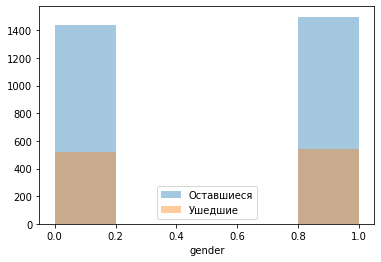

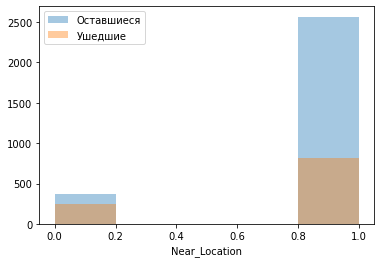

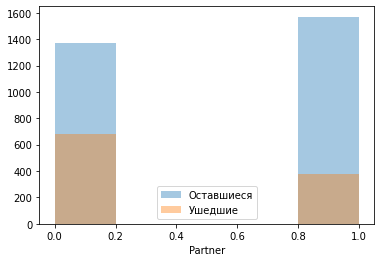

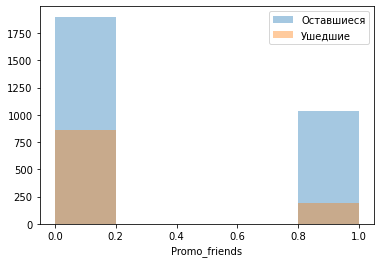

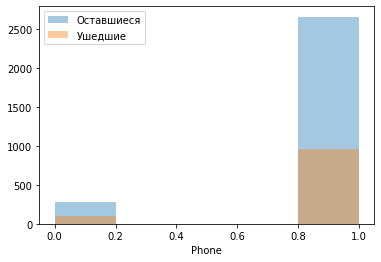

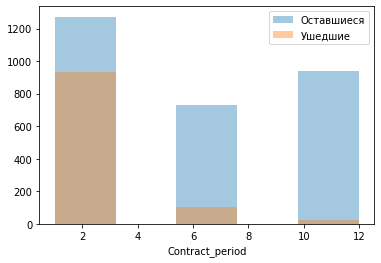

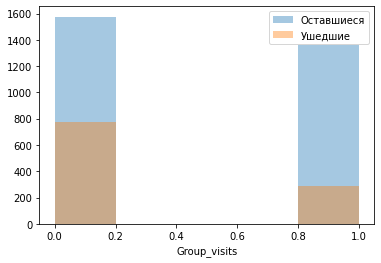

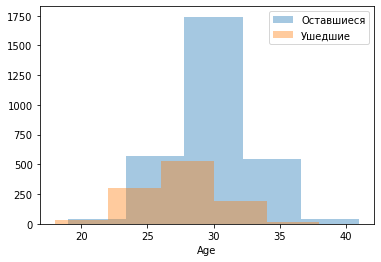

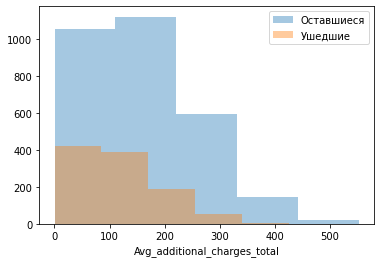

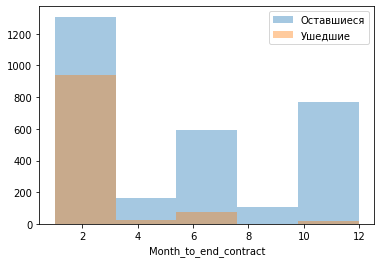

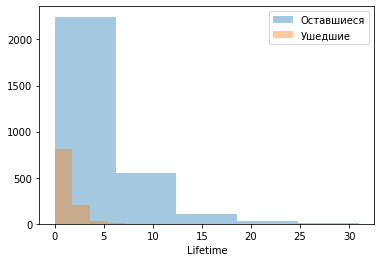

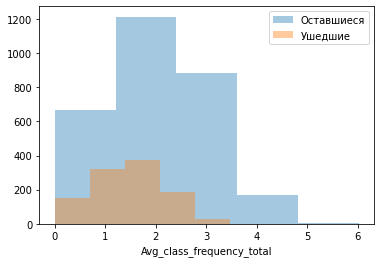

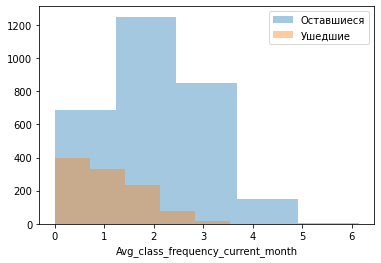

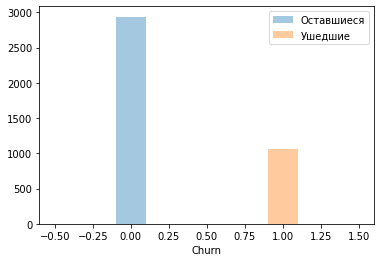

In [8]:
stay = df.query('Churn == 0')
left = df.query('Churn == 1')
for feature in df.columns:
    sns.distplot(stay[feature],label = 'Оставшиеся', bins = 5,kde=False),
    sns.distplot(left[feature],label = 'Ушедшие', bins = 5,kde=False)
    plt.legend()
    plt.show()

**Вывод**

Клиенты, у которых были длительные контракты, реже покидают фитнесс-клуб. Пользователи, кто уходит контракты заключили не так давно.Ушедшие клиенты практически не тратили деньги в фитнес-клубе, в отличие от освтавшихся клиентов. Ушедшие клиенты практически не тратили деньги в фитнес-клубе, в отличие от оставшихся клиентов.

**Построим матрицу корреляций и отобразим её**

In [9]:
df.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


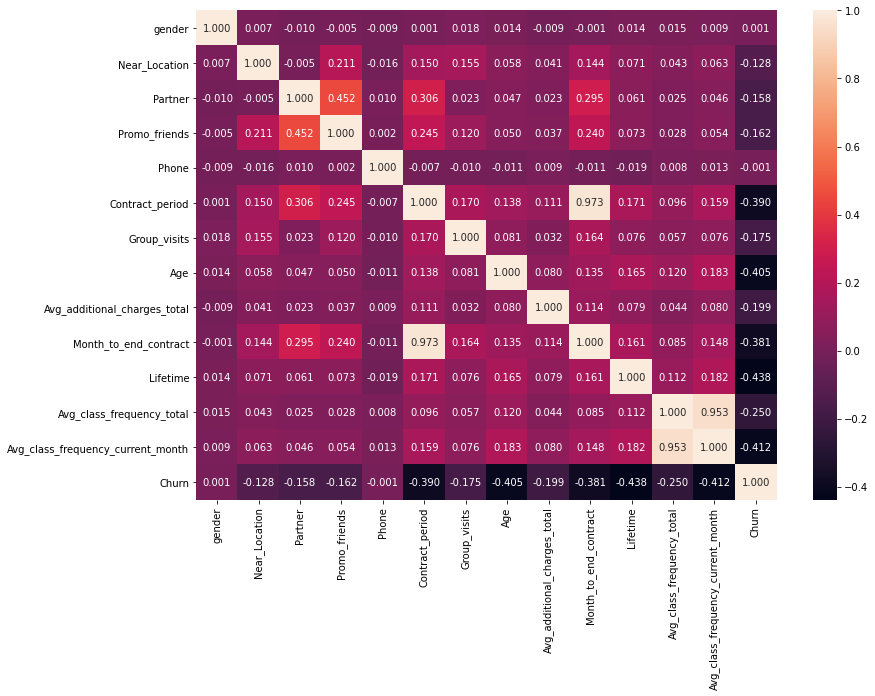

In [10]:
fig, ax = plt.subplots(figsize=(13, 9)) #Отобразим матрицу корреляций на тепловой карте
sns.heatmap(df.corr(), annot = True, fmt = '.3f')
plt.show()

**Вывод**

Чем больше компаний-партнеров, тем больше приводят друзей с дальнейшей покупкой длительных абонеменов и те кто живут и работают рядом со спорт-клубом, соглашаются также приоритетнее.

Также большая корреляция у Contract_period('Длительность текущего действующего абонемента') и Month_to_end_contract('срок до окончания текущего действующего абонемента').

## Построим модель прогнозирования оттока клиентов

In [11]:
X = df.drop('Churn', axis = 1) #разделим данные на признаки (матрица X) и целевую переменную (y)
y = df['Churn']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #pазобьем данные на обучающую и валидационную выборку функцией с помощью train_test_split()

In [13]:
scaler = StandardScaler() #создадим объект класса StandardScaler и применим его к обучающей и тестовой выборкам
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

**Обучим модель на train-выборке двумя способами:**

**логистической регрессией,
случайным лесом**

In [14]:
models = [LogisticRegression(random_state = 0),RandomForestClassifier(random_state = 0)]  # зададим список моделей

In [15]:
def make_prediction(m, X_train, y_train, X_test, y_test): #создадим функцию, которая принимает на вход модель и данные и выводит метрики
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(accuracy_score(y_test, y_pred), 
                                                         precision_score(y_test, y_pred),
                                                         recall_score(y_test, y_pred)))

In [16]:
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Accuracy:0.92 Precision:0.85 Recall:0.83
RandomForestClassifier(random_state=0)
Accuracy:0.92 Precision:0.84 Recall:0.81


**Вывод**

Логистическая регрессия выглядит лучше, чем модель случайного леса.

## Сделаем кластеризацию клиентов

In [17]:
sc = StandardScaler()  #стандартизация данных
X_sc = sc.fit_transform(X)

In [18]:
linked = linkage(X_sc, method = 'ward') #построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков 

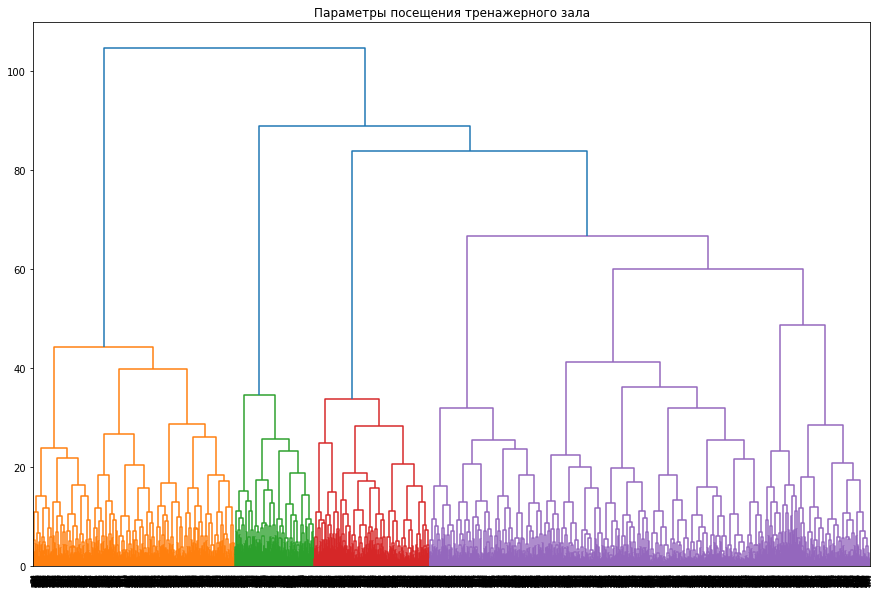

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Параметры посещения тренажерного зала')
plt.show()

**Вывод**

 Получили 4 кластера

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов**

In [20]:
km = KMeans(n_clusters = 4)
labels = km.fit_predict(X_sc)

In [21]:
df['cluster'] = labels

In [22]:
df_cluster = df.groupby('cluster').mean() #посмотрим на средние значения признаков для кластеров
df_cluster.T

cluster,0,1,2,3
gender,0.523316,0.545802,0.502321,0.487576
Near_Location,0.862694,0.863550,0.940576,0.758899
Partner,0.471503,0.347328,0.777159,0.378778
Promo_friends,0.305699,0.209924,0.571959,0.188046
Phone,0.000000,1.000000,1.000000,1.000000
Contract_period,4.777202,2.430344,10.707521,1.881800
Group_visits,0.427461,0.453244,0.535747,0.290128
Age,29.297927,30.033397,29.882080,28.052384
Avg_additional_charges_total,144.208179,158.217589,161.226639,129.387127
Month_to_end_contract,4.466321,2.264313,9.778087,1.788449


**Вывод**

У первого кластера(0) отток 56% и почти все показатели ниже остальных, в том числе Групповые визиты, самый маленький срок до окончания текущего действующего абонемента и средняя частота посещений в неделю за все время с начала действия абонемента.

У второго кластера (1) и четвертого кластера(3) стабильно средние показатели.

У третьего кластера(2) почти все показатели чуть выше остальных и самый низкий отток посетителей.

**Построим распределение признаков для кластеров**


In [23]:
df_1 = df.drop(['Age', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'], axis = 1)
df_2 = df.drop(['Month_to_end_contract', 'Group_visits', 'Contract_period', 'Phone', 'Promo_friends', 'Partner', 'Churn', 'Near_Location', 'gender'], axis = 1)

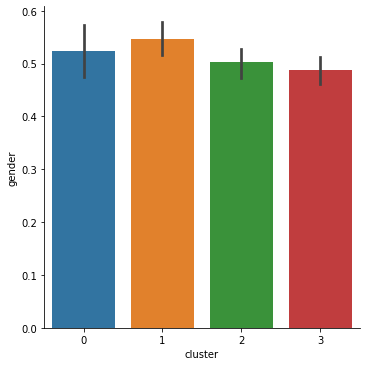

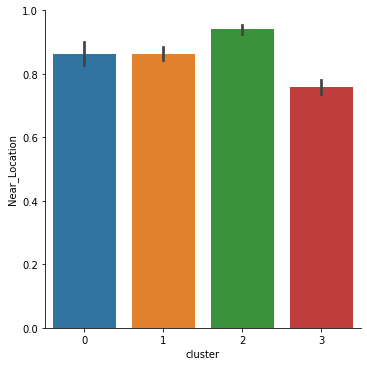

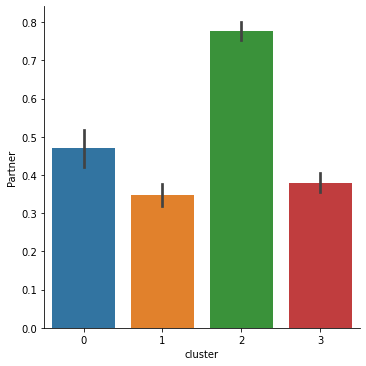

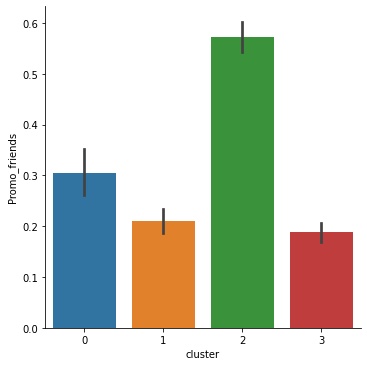

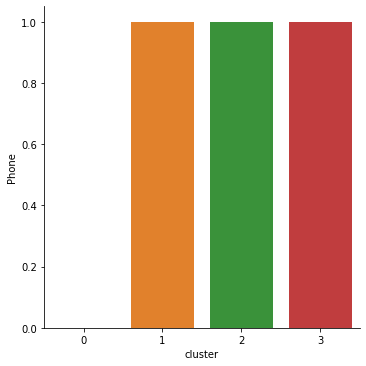

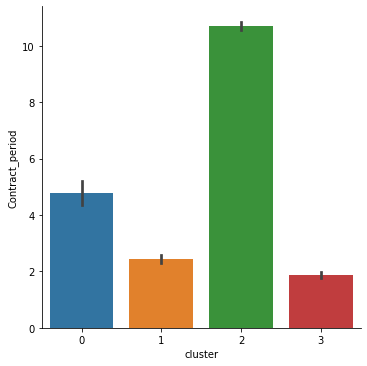

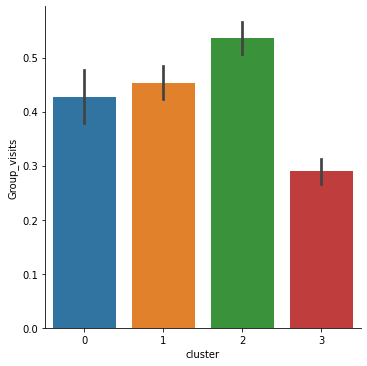

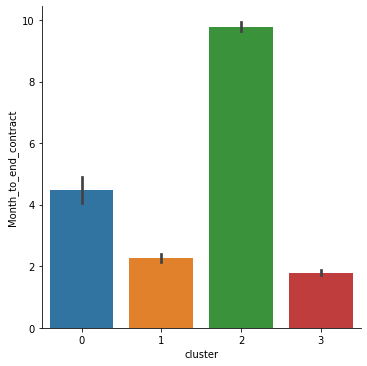

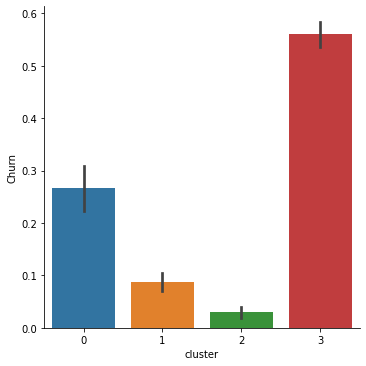

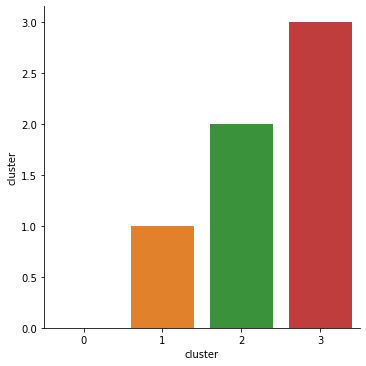

In [24]:
for column in df_1:
    sns.catplot(x= 'cluster', y= column, data=df_1, kind = 'bar')
    plt.show()

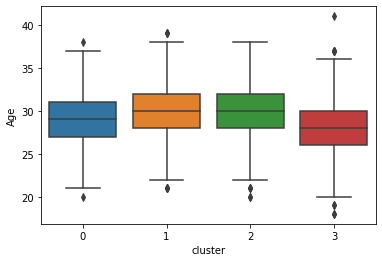

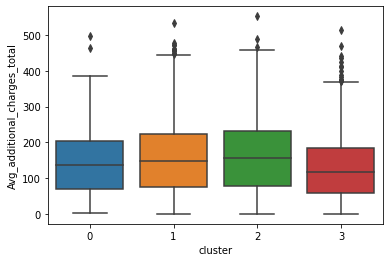

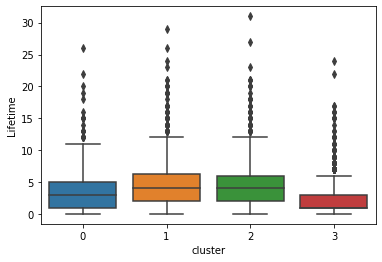

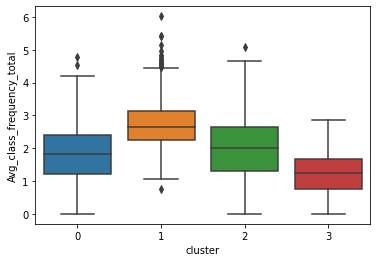

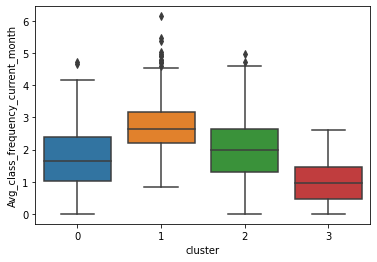

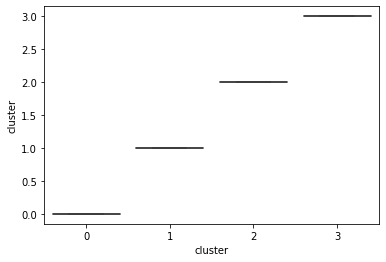

In [25]:
for column in df_2:
    sns.boxplot(x= 'cluster', y= column, data=df_2)
    plt.show()

**Вывод**

Наблюдения в корреляционной матрице подтвердились графиками.

**Посчитаем долю оттока кластеров**

In [26]:
df['count'] = 1
leavers = df.query('Churn == 1')
leavers = leavers.groupby('cluster').agg({'count':'sum'}).reset_index()
clusters = df.groupby('cluster').agg({'count':'sum'}).reset_index()
left_percent = clusters.merge(leavers, on = 'cluster')
left_percent

,cluster,count_x,count_y
0,0,386,103
1,1,1048,92
2,2,1077,32
3,3,1489,834


In [27]:
left_percent['left%'] = left_percent['count_y'] / left_percent['count_x'] * 100
left_percent['left%'] = left_percent['left%'].apply(np.ceil)
left_percent

,cluster,count_x,count_y,left%
0,0,386,103,27.0
1,1,1048,92,9.0
2,2,1077,32,3.0
3,3,1489,834,57.0


**Вывод**

У первого кластера(0) отток 57% и почти все показатели ниже остальных, в том числе Групповые визиты, самый маленький срок до окончания текущего действующего абонемента и средняя частота посещений в неделю за все время с начала действия абонемента.

У второго кластера (1) отток 10%, у четвертого кластера(3) отток 27%.

У третьего кластера(2) почти все показатели чуть выше остальных и самый низкий отток посетителей (3%).

**ОБЩИЙ ВЫВОД**

В основном отток идет среди тех клиентов, у которых краткосрочные абонементы, которые не очень часто посещают заведение, которые не склонные тратить деньги на какие-то дополнительные услуги. Как вариант удержания- возможно стоит ввести специальные предложения (Пример - продавать выгодные пакеты абонементов, где, допустим будет посещение + еще что-то как подарок(бассейн, сауна, бокс, аэробика).

По результатам выделения кластеров можно заметить, что хорошо себя показывают партнерские программы, которые находятся недалеко от спорт-клуба. Предлагать им 6 месячные, годовые абонементы будет выгодно.